# Cup Validation

This file is built around validation of the model that has been trained. This file has more printouts than the associated api file and is a better visualisation of what the system does in regards to the RCNN model so far.

In [9]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import json
from flask import jsonify

sys_config=json.load(open("config.json", 'r'))

# Root directory of the project. We use the working directory of the notebook here as a startpoint so don't need to change
# this in the notebook.
ROOT_DIR = os.path.abspath("/")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import bowls as bowl

%matplotlib inline 

Begin a configuration of the cup dataset we are going to use. We use the inference mode of the data for validation as is standard for ML models. We only want to detect on 1 input at a time here because there is no need to have it higher. This block will also display the configuration of the model in full. This is good for tensorflow debug purposes.

In [10]:
config = bowl.BowlConfig()

class InferenceConfig(config.__class__):
    # Make sure we only run detection 1 at a time
    # This value may be increased when moved to cloud
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE=0.96

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.96
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

This fn essentially allows a base size for graphs below. This is a common thing i've seen in notebooks with matplotlib and see no reason not to use it here.

In [11]:
def get_ax(rows=1, cols=1, size=16):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

&nbsp;

Within our dataset of annotated cup images, I have split into train and validation images. This section below uses the 3 validation images which have annotations already attached for AP values later. The printout states 2 layers in the image (BG and Cup). This is how the RCNN splits up images, into background and chosen objects. 

In [14]:
# Load validation dataset
dataset = bowl.BowlDataset()
dataset.load_Bowl(sys_config["cup directory"], "val")

# Must call before using the dataset as per mrcnn
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 9
Classes: ['BG', 'bowl']


In [15]:
# Create model in inference mode
with tf.device(sys_config["device"]):
    global bowl_model
    bowl_model = modellib.MaskRCNN(mode=sys_config["mode"], model_dir=sys_config["bowl"]["model directory"],
                              config=config)
    try:
        print("Loading bowl weights ", sys_config["bowl"]["weights path"])
        bowl_model.load_weights(sys_config["bowl"]["weights path"], by_name=True)
    except:
        print("Bowl weights file unable to be loaded".format(error))

Loading bowl weights  C:\Users\AdamG\OneDrive\Documents\Projects\Uni\FYP\API\logs\bowls\mask_rcnn_bowl_0021.h5


&nbsp;

Here we start to actually use the model we have trained. Below is a print of a rough prediction of where the detected cup is in the image. For the process of this initial prototype I used a small training set of 10 images and 17 epochs (100 steps/e) in the interest of time. A more extensive training set will be used in the final product.

This block chooses a random image from the validation set to used. This image is saved and used throughout the remainder of the notebook.

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -121.70000  max:  142.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


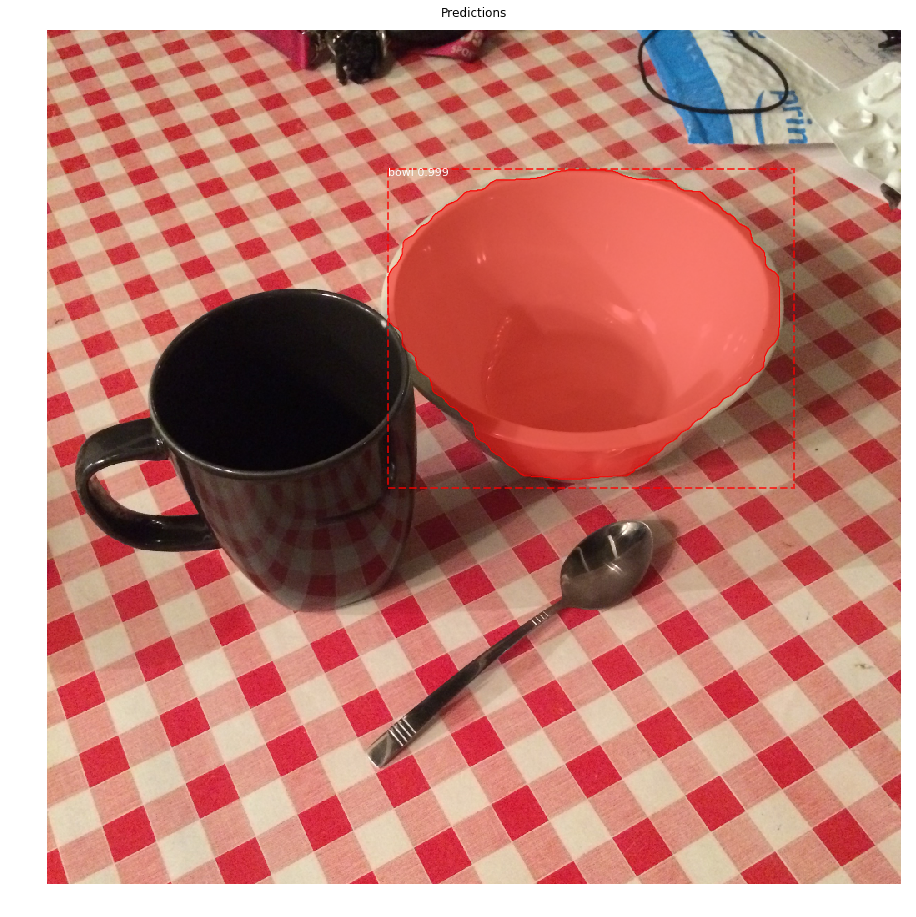

In [16]:
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, 8, use_mini_mask=False)

# Run object detection
results = bowl_model.detect([image], verbose=1)

# Display results
ax = get_ax()
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [7]:
print (r['rois'])
print ("-------------------")
print (r['rois'][0])

[[384 680 608 926]
 [429 435 735 725]
 [329  37 633 415]]
-------------------
[384 680 608 926]


In [8]:
#rois: [N, (y1, x1, y2, x2)] detection bounding boxes
#Will return x, y, relative x, relative y, and cropped image
def final_ret(image, roi):
    img=image[roi[0]:roi[2], roi[1]:roi[3]]
    centre = find_box_center(roi, image)
    plt.imshow(img)
    plt.savefig("logs/Detection_test_{}".format(roi))
    return {"image":img.tolist(), "centre": centre}

In [9]:
def find_box_center(roi, image):
    true_y = (roi[0]+roi[2])/2
    true_x = (roi[1]+roi[3])/2
    rel_roi = []
    for i in roi:
        #The shape of the image is normalised to square so we don't need to
        #worry about different x and y shapes
        rel_roi.append((i/image.shape[0])*100)
    rel_y = np.round((rel_roi[0]+rel_roi[2])/2, 2)
    rel_x = np.round((rel_roi[1]+rel_roi[3])/2, 2)

    return ([true_y, true_x, rel_y, rel_x])

In [10]:
def detect_boxes_and_crop(image):
    imgs=[]
    for i in range(len(r['rois'])):
        plt.axis('off')
        box_ret = final_ret(image, r['rois'][i])
        filename=("detect_tst_{}.png".format(i))
        imgs.append(box_ret)
    return imgs

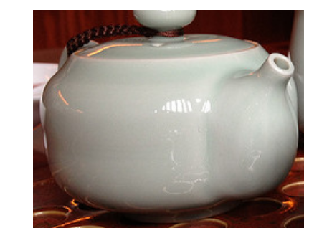

In [11]:
image_list=detect_boxes_and_crop(image)
with open('logs/test_data.json', 'w') as outfile:
    json.dump(image_list, outfile)